In [1]:
import jax.numpy as jnp
from jax import jit 
from jax.flatten_util import ravel_pytree

import numpy as np
import scipy
import matplotlib.pyplot as plt
import interpax

from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
from mechanics import *
from data_reading import *
import progressbar

In [2]:
N = 0
size = 100
mode = "chaos"

"""
    Reads in necessary parameters from config.ini
"""

print("Preparing data...")
N,size,[] = read_config([])

print("Reading data...")
x_temp = read_vector("../data/SpringMassModel/x.csv",(N,2,size+1,size+1))
x_cm_temp = read_vector("../data/SpringMassModel/x_cm.csv",(N,2,size+1,size+1))
T = read_scalar("../data/SpringMassModel/T.csv",(1,N,size,size))[0]

Preparing data...
Reading data...
shape of data:  (2000, 2, 101, 101)


100% |########################################################################|


shape of data:  (2000, 2, 101, 101)


100% |########################################################################|


shape of data:  (1, 2000, 100, 100)


100% |########################################################################|


In [3]:
def define_system(**kwargs_sys):

    #bounds for parameters
    nu_min, nu_max = kwargs_sys['nu_min'], kwargs_sys['nu_max']
    m_min, m_max = kwargs_sys['m_min'], kwargs_sys['m_max']
    l_g_min, l_g_max = kwargs_sys['l_g_min'], kwargs_sys['l_g_max']
    l_p_min, l_p_max = kwargs_sys['l_p_min'], kwargs_sys['l_p_max']
    k_g_min, k_g_max = kwargs_sys['k_g_min'], kwargs_sys['k_g_max']
    k_a_min, k_a_max = kwargs_sys['k_a_min'], kwargs_sys['k_a_max']
    k_p_min, k_p_max = kwargs_sys['k_p_min'], kwargs_sys['k_p_max']
    eta_min, eta_max = kwargs_sys['eta_min'], kwargs_sys['eta_max']

    # Interpolated params and coresponding time ,
    x_cm_arr = kwargs_sys['x_cm']
    x_j_arr = kwargs_sys['x_j']
    l_a_arr = kwargs_sys['l_a']
    

    def gen_y0():

        #takes initial conditions from kwargs(data)
        x1_0 = kwargs_sys['x1_0']
        x2_0 = kwargs_sys['x2_0']
        y1_0 = kwargs_sys['y1_0']
        y2_0 = kwargs_sys['y2_0']

        return {'x1':x1_0, 'x2':x2_0, 'y1':y1_0, 'y2':y2_0}

    def gen_params():

        nu = nu_min + (nu_max - nu_min) * np.random.rand()
        m = m_min + (m_max - m_min) * np.random.rand()

        l_g = l_g_min + (l_g_max - l_g_min) * np.random.rand()
        l_p = l_p_min + (l_p_max - l_p_min) * np.random.rand()

        k_g = k_g_min + (k_g_max - k_g_min) * np.random.rand()
        k_a = k_a_min + (k_a_max - k_a_min) * np.random.rand()
        k_p = k_p_min + (k_p_max - k_p_min) * np.random.rand()
        
        eta = eta_min + (eta_max - eta_min) * np.random.rand()

        return {'nu':nu,'m':m,'l_g':l_g,'l_p':l_p,'k_g':k_g, 'k_a':k_a,'k_p':k_p, 'eta':eta}, {}, {}

        
    @jit
    def eom(xy, t, params, iparams, exparams):
        x = jnp.array([xy['x1'], xy['x2']])
        # get interpolated parameters at corresponding time
        x_cm = t_to_value_4p(x_cm_arr,t_interp,t)
        x_j = t_to_value_4p(x_j_arr,t_interp,t)
        l_a = t_to_value_1p(l_a_arr,t_interp,t)

        #initialize total force
        f = total_force(x, x_j, x_cm, l_a, t, params)

        #initialize eom
        dx1 = xy['y1']
        dx2 = xy['y2']
        dy1 = 1/params['m'] * (f[1] - params['nu'] * xy['y1'])
        dy2 = 1/params['m'] * (f[2] - params['nu'] * xy['y2'])

        return {'x1':dx1, 'x2':dx2, 'y1':dy1, 'y2':dy2}

    @jit
    def loss(xy, params, iparams, exparams, targets):
        
        x1 = xy['x1']
        x2 = xy['x2']
        t_x1 = targets['x1']
        t_x2 = targets['x2']
        return jnp.nanmean((x1-t_x1)**2 + (x2-t_x2)**2)

    return eom, loss, gen_params, gen_y0, {}

In [4]:
N,size,ls = read_config(["l_0","c_a","k_ij","k_j","k_a","m","c_damp","n_0","delta_t_m","it_m","pad"])
l_0, c_a, k_g0, k_p0, k_a0, m0, nu0, eta0, delta_t_m, it_m, pad = ls
l_a0,l_p0,l_g0 = l_0, l_0, l_0

real_params = {'l_a':l_a0,'l_p':l_p0,'l_g':l_g0,'c_a':c_a,'k_g':k_g0,'k_p':k_p0,'k_a':k_a0,'m':m0,'nu':nu0,'eta':eta0}

delta_t = delta_t_m * it_m
t_evals = jnp.linspace(0,2000*delta_t,2000)
N_interp = 50

x_i,x_j,x_cm,l_a = shape_input_for_adoptode(x_temp, x_cm_temp,T,50,50) #the last two variables define the cell in the grid 
t_interp, x_cm_interp = interpolate_x(x_cm,t_evals,N_interp)
t_interp, x_j_interp = interpolate_x(x_j,t_evals,N_interp)
t_interp, l_a_interp = interpolate_scalar(l_a,t_evals,N_interp)

y0 = {"x1":x_i[0,0],'x2':x_i[0,1],'y1':(x_i[1,0]-x_i[0,0])/delta_t,'y2':(x_i[1,1]-x_i[0,1])/delta_t,'x_cm':x_cm[:,0,:],'x_j':x_j[:,0,:]}


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(4, 2000)


In [5]:
x_i.shape

(2000, 2)

In [6]:
rel_err = 0
kwargs_sys = { 
    'nu_min': nu0 - nu0 *rel_err,'nu_max': nu0 + nu0 *rel_err,
    'm_min': m0 - m0 *rel_err,'m_max' : m0 + m0 *rel_err,
    'l_g_min': l_g0 - l_g0 *rel_err,'l_g_max': l_g0 + l_g0 *rel_err,
    'l_p_min': l_p0 - l_p0 *rel_err,'l_p_max': l_p0 + l_p0 *rel_err,
    'k_g_min': k_g0 - k_g0 *rel_err,'k_g_max': k_g0 + k_g0 *rel_err,
    'k_p_min': k_p0 - k_p0 *rel_err,'k_p_max': k_p0 + k_p0 *rel_err,
    'k_a_min': k_a0 - k_a0 *rel_err,'k_a_max': k_a0 + k_a0 *rel_err,
    'eta_min': eta0 - eta0 *rel_err,'eta_max': eta0 + eta0 *rel_err,
    't_interp': t_interp,
    'N_interp': N_interp,
    'x_cm':x_cm_interp,
    'x_j':x_j_interp,
    'l_a':l_a_interp,
    'x1_0':x_i[0,0],
    'x2_0':x_i[0,1],
    'y1_0':(x_i[1,0]-x_i[0,0])/delta_t,
    'y2_0':(x_i[1,1]-x_i[0,1])/delta_t,
    'N_sys': 1
}
tol = .5
real_params_low = {'l_a':l_a0- l_a0*tol,'l_p':l_p0- l_p0*tol,'l_g':l_g0- l_g0*tol,'c_a':c_a - c_a*tol,'k_g':k_g0- k_g0*tol,'k_p':k_p0- k_p0*tol,'k_a':k_a0- k_a0*tol,'m':m0- m0*tol,'nu':nu0- nu0*tol,'eta':eta0- eta0*tol}
real_params_up = {'l_a':l_a0+ l_a0*tol,'l_p':l_p0+ l_p0*tol,'l_g':l_g0+ l_g0*tol,'c_a':c_a + c_a*tol,'k_g':k_g0+ k_g0*tol,'k_p':k_p0+ k_p0*tol,'k_a':k_a0+ k_a0*tol,'m':m0+ m0*tol,'nu':nu0+ nu0*tol,'eta':eta0+ eta0*tol}
kwargs_adoptODE = {'lr':3e-2, 'epochs':200,'N_backups':5,
                   'lower_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']-0.1*y0['y1'],'y2':y0['y2']-0.1*y0['y2'] },
                   'upper_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']+0.1*y0['y1'],'y2':y0['y2']+0.1*y0['y2'] }
                   }
dataset = simple_simulation(define_system,
                                t_evals,
                                kwargs_sys,
                                kwargs_adoptODE)


Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=6/0)>
Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=6/0)>


In [18]:
def euler_step(xy,t,real_params):
    dxy = sm_eom(xy,t,real_params)

    x1 = xy['x1'] + dxy['x1'] * delta_t_m
    x2 = xy['x2'] + dxy['x2'] * delta_t_m
    y1 = xy['y1'] + dxy['y1'] * delta_t_m   
    y2 = xy['y2'] + dxy['y2'] * delta_t_m

    xy = {'x1':x1,'x2':x2,'y1':y1,'y2':y2}
    t = t + delta_t_m

    return xy, t


def sm_eom(xy, t, params):
    x = jnp.array([xy['x1'], xy['x2']])
    # get interpolated parameters at corresponding time
    x_cm_temp = t_to_value_4p(x_cm_interp,t_interp,t)
    x_j_temp = t_to_value_4p(x_j_interp,t_interp,t)
    l_a_temp = t_to_value_1p(l_a_interp,t_interp,t)

    #initialize total force
    f = total_force(x, x_j_temp, x_cm_temp, l_a_temp, t, params)
    
    plt.scatter(t,l_a_temp[0],color = 'red')

    #initialize eom
    dx1 = xy['y1']
    dx2 = xy['y2']
    dy1 = 1/params['m'] * (f[1] - params['nu'] * xy['y1'])
    dy2 = 1/params['m'] * (f[2] - params['nu'] * xy['y2'])

    return {'x1':dx1, 'x2':dx2, 'y1':dy1, 'y2':dy2}

def euler(xy0,iterations,real_params):
#returns a list of all iterations of the system after iterating the euler method
    xy = xy0
    t = 0
    xy_list = [xy['x1']]
    t_list = [t]
    for i in range(iterations):
        xy, t = euler_step(xy,t,real_params)
        t_list.append(t)
        xy_list.append(xy['x1'])
    return xy_list,t_list


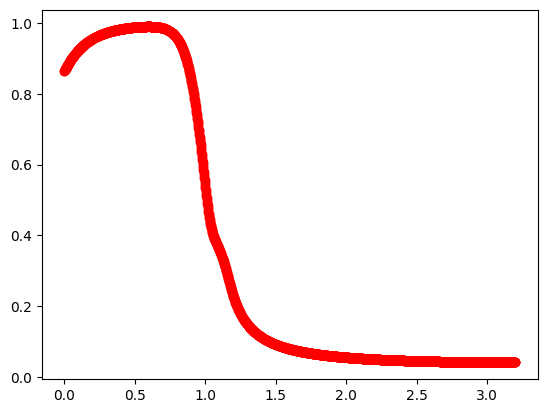

In [19]:
x,t =euler(y0,2000,real_params)

In [20]:
l_a.shape

(4, 2000)

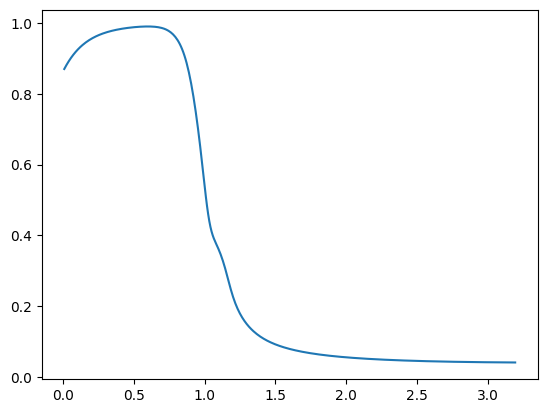

In [22]:
plt.plot(t_evals[1:400],l_a[0,1:400])
#plt.plot(t_evals[0:400],x_i[0:400,0])

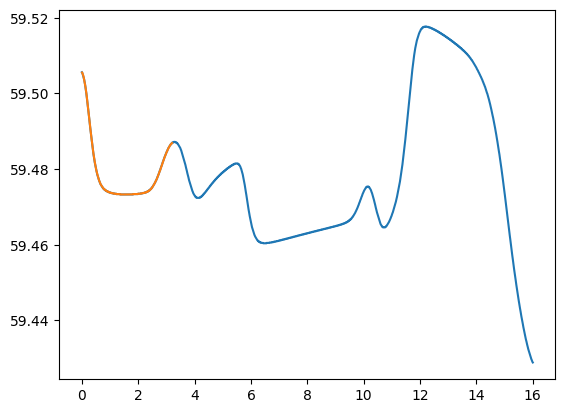

In [9]:
plt.plot(t_evals,x_cm[0,:,0])
plt.plot(t[5:],x_cmlist[5:])

In [20]:
len(x_cmlist)
len(x_cm[0,:,0])

2000

In [39]:
print(x_i[0,0],x[0])

60.0054 60.0054


In [40]:
i=3
f_test = f_ij(x_i[1,:],x_j[i,0,:],real_params['k_g'],1)
x_i_test = x_i[0,:]
x_i_pf_test = x_i_test + f_test

print(f_test,jnp.linalg.norm(x_i[1,:]-x_j[i,1,:]))
#plot arrow from x_i_test to x_i_pf_test


[ 0.00520706 -0.        ] 0.9996


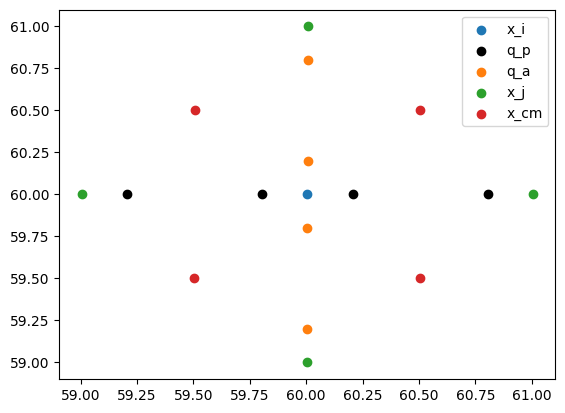

In [41]:
q_a =  interpolate_q_a(x_j[:,1,:],x_i[1,:],.8)
q_p = interpolate_q_p(x_j[:,1,:],x_i[1,:],.8)

# #plt.scatter(x_i_pf_test[0],x_i_pf_test[1],label='x_i_pf',color = 'purple')
# plt.scatter(q_p[0,0],q_p[0,1],label='q_p0',color = 'black')
# plt.scatter(q_p[1,0],q_p[1,1],label='q_p1',color = 'black')
# plt.scatter(q_p[2,0],q_p[2,1],label='q_p2',color = 'black')
# plt.scatter(q_p[3,0],q_p[3,1],label='q_p3',color = 'black')

# plt.scatter(q_a[0,0],q_a[0,1],label='q_a0',color = 'blue')
# plt.scatter(q_a[1,0],q_a[1,1],label='q_a1',color = 'blue')
# plt.scatter(q_a[2,0],q_a[2,1],label='q_a2',color = 'blue')
# plt.scatter(q_a[3,0],q_a[3,1],label='q_a3',color = 'blue')

plt.scatter(x_i[1,0],x_i[1,1],label='x_i')
plt.scatter(q_p[:,0],q_p[:,1],label='q_p',color = 'black')
plt.scatter(q_a[:,0],q_a[:,1],label='q_a')
plt.scatter(x_j[:,1,0],x_j[:,1,1],label='x_j')
plt.scatter(x_cm[:,1,0],x_cm[:,1,1],label='x_cm')
plt.legend()

In [42]:
# active/passi axial points qa 0 to 3; Mass point x; eta > 1/2
#
#              0
#              q0\    
#        xcm0\    \xcm1
#         /   \q1   /  
#  3  q0a/ /q1a x q2a  /q3a 1 
#         /    q2\    /  
#        xcm3\    \xcm2     
#             \q3
#              2
#
# shape(q)  = (N,2,4)

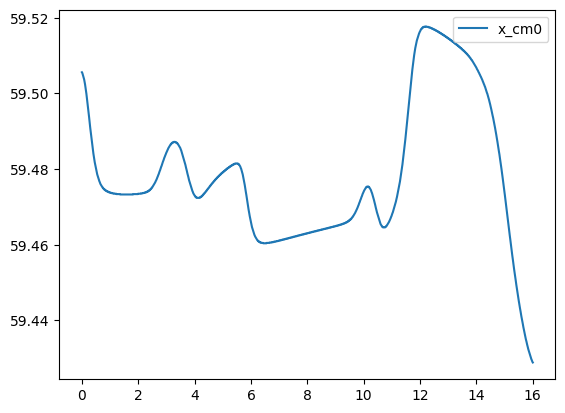

In [43]:
#plt.scatter(t,x)
# plt.plot(t_evals,x_i[:,0],label="x_i")
# plt.plot(t_evals,x_j[0,:,0],label="x_j0")
# plt.plot(t_evals,x_j[1,:,0],label = "x_j1")
# plt.plot(t_evals,x_j[2,:,0],label = "x_j2")
# plt.plot(t_evals,x_j[3,:,0],label = "x_j3")

plt.plot(t_evals,x_cm[0,:,0],label = "x_cm0")
# plt.plot(t_evals,x_cm[1,:,0],label = "x_cm1")
# plt.plot(t_evals,x_cm[2,:,0],label = "x_cm2")
# plt.plot(t_evals,x_cm[3,:,0],label = "x_cm3")
plt.legend()

In [44]:
print('The true parameters used to generate the data: ', dataset.params)
print('The initial gues of parameters for the recovery: ', dataset.params_train )

The true parameters used to generate the data:  {'nu': 15.0, 'm': 1.0, 'l_g': 1.0, 'l_p': 1.0, 'k_g': 13.0, 'k_a': 9.0, 'k_p': 2.0, 'eta': 0.5}
The initial gues of parameters for the recovery:  {'nu': 15.0, 'm': 1.0, 'l_g': 1.0, 'l_p': 1.0, 'k_g': 13.0, 'k_a': 9.0, 'k_p': 2.0, 'eta': 0.5}


In [45]:
_ = train_adoptODE(dataset)
print('True params: ', dataset.params)
print('Found params: ', dataset.params_train)

Epoch 000:  Loss: 0.0e+00,  Params Err.: 0.0e+00, y0 error: 0.0e+00, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 020:  Loss: 0.0e+00,  Params Err.: 0.0e+00, y0 error: 0.0e+00, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 040:  Loss: 0.0e+00,  Params Err.: 0.0e+00, y0 error: 0.0e+00, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 060:  Loss: 0.0e+00,  Params Err.: 0.0e+00, y0 error: 0.0e+00, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 080:  Loss: 0.0e+00,  Params Err.: 0.0e+00, y0 error: 0.0e+00, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 100:  Loss: 0.0e+00,  Params Err.: 0.0e+00, y0 error: 0.0e+00, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 120:  Loss: 0.0e+00,  Params Err.: 0.0e+00, y0 error: 0.0e+00, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 140:  Loss: 0.0e+00,  Params

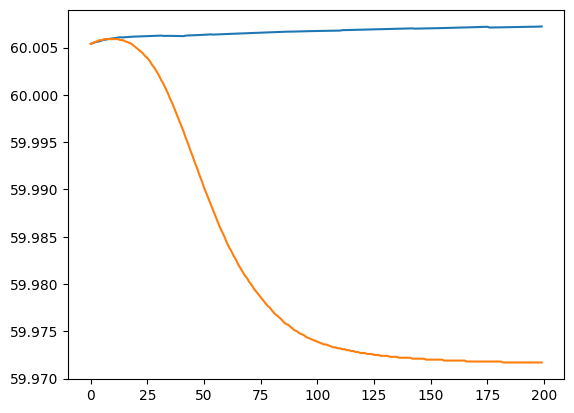

In [46]:
plt.plot(dataset.ys_sol['x1'][0,0:200])
plt.plot(x_i[0:200,0])

In [47]:
reset_every = 50
t_reset_idcs = tuple([
    reset_every * i
    for i in range(int(np.ceil((len(t_evals) - 1) / reset_every)))
])

In [48]:
nan_array1 = jnp.full((1, 2000), 1.)
nan_array2 = jnp.full((1, 2000), 1.)


kwargs_adoptODE = {'lr':3e-2, 'epochs':200,'N_backups':5,
                   'lower_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']-0.1*y0['y1'],'y2':y0['y2']-0.1*y0['y2'] },
                   'upper_b_y0':{'x1':y0['x1'],'x2':y0['x2'],'y1':y0['y1']+0.1*y0['y1'],'y2':y0['y2']+0.1*y0['y2'] },
                   'lower_b': real_params,
                   'upper_b': real_params}

targets = {"x1":x_i[:,0].reshape((1,2000)),'x2':x_i[:,1].reshape((1,2000)),'y1':nan_array1,'y2':nan_array2}
dataset2 = dataset_adoptODE(define_system,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE
                                )

In [49]:
_ = train_adoptODE(dataset2)

print('Found params: ', dataset2.params_train)

Epoch 000:  Loss: 1.2e-03,  Params Err.: nan, y0 error: nan, Params Norm: 2.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 020:  Loss: 1.6e-03,  Params Err.: nan, y0 error: nan, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 040:  Loss: 1.6e-03,  Params Err.: nan, y0 error: nan, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 060:  Loss: 1.6e-03,  Params Err.: nan, y0 error: nan, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 080:  Loss: 1.6e-03,  Params Err.: nan, y0 error: nan, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 100:  Loss: 1.6e-03,  Params Err.: nan, y0 error: nan, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 120:  Loss: 1.6e-03,  Params Err.: nan, y0 error: nan, Params Norm: 1.9e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 140:  Loss: 1.6e-03,  Params Err.: nan, y0 error: nan, Params Norm: 1.9e+01, iParams

In [50]:
print(y0['x1'],dataset2.ys_sol['x1'][0,0])

60.0054 60.0054


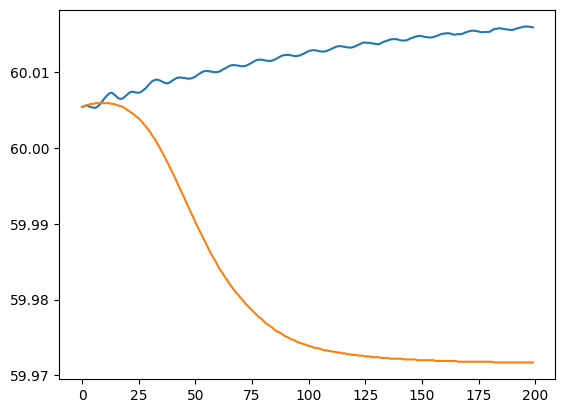

In [51]:
plt.plot(dataset2.ys_sol['x1'][0,0:200])
plt.plot(x_i[0:200,0])